In [1]:
#Import Kaggle dataset
import os
from pathlib import Path

os.environ["KAGGLE_KEY"] = os.getenv('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = os.getenv('KAGGLE_USERNAME')


In [11]:
import kagglehub

asl_dataset = "ayuraj/asl-dataset"
asl_alphabet = "grassknoted/asl-alphabet"
path = kagglehub.dataset_download(asl_alphabet)
print(f"Path to dataset files:{path}")


100%|██████████| 1.03G/1.03G [02:10<00:00, 8.46MB/s]

Extracting files...


Path to dataset files:/home/mich02/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1


In [ ]:
# First dataset
!apt-get install tree
!kaggle datasets download -d ayuraj/asl-dataset
! unzip -q "/content/asl-dataset.zip"

!kaggle datasets download -d grassknoted/asl-alphabet
! unzip -q "/content/asl-alphabet.zip"

!mv asl_alphabet_train/asl_alphabet_train/* asl_alphabet_train/
!rm -r asl_alphabet_train/asl_alphabet_train/
!mv asl_alphabet_test/asl_alphabet_test/* asl_alphabet_test/
!rm -r asl_alphabet_test/asl_alphabet_test/

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Dataset URL: https://www.kaggle.com/datasets/ayuraj/asl-dataset
License(s): CC0-1.0
User cancelled operation
^C
unzip:  cannot find or open /content/asl-dataset.zip, /content/asl-dataset.zip.zip or /content/asl-dataset.zip.ZIP.
Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0


/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/ai4li_vsl_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Exception ignored in: <function tqdm.__del__ at 0x7bfc34492c00>
Traceback (most recent call last):
  File "/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/ai4li_vsl_env/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/ai4li_vsl_env/lib/python3.12/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Found 2515 images to process
Using 22 workers


Saving random-bg dataset: 100%|██████████| 2515/2515 [00:48<00:00, 51.38it/s]



Done. Saved: 2515  |  Failed: 0  |  Out dir: /home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset_random_bg_noise


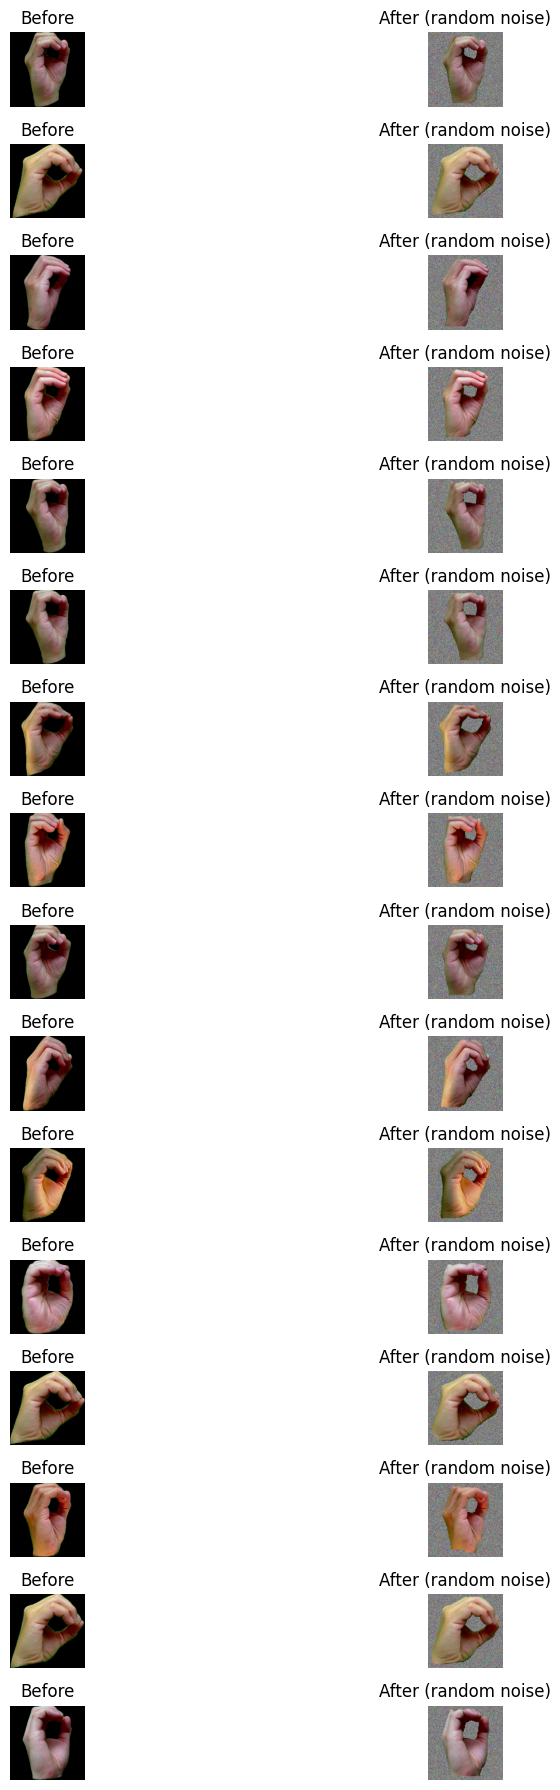

In [4]:
# ===================== Random BG saver - Local Machine Version =====================
# Saves outputs to a new dataset folder, preserving 0-9/a-z subfolders
# ====================================================================================

import os
import glob
import random
from typing import List, Tuple
from pathlib import Path

import numpy as np
import cv2

import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing as mp
from tqdm.auto import tqdm


# -------------------- helpers --------------------
def list_images_recursive(root: str, exts=(".jpg", ".jpeg", ".png", ".bmp", ".webp")) -> List[str]:
    root = os.path.abspath(root)
    paths = []
    for d in sorted(os.listdir(root)):
        sub = os.path.join(root, d)
        if not os.path.isdir(sub):
            continue
        for ext in exts:
            paths.extend(glob.glob(os.path.join(sub, f"*{ext}")))
    return paths

def _read_image_any(x):
    if isinstance(x, str):
        img = cv2.imread(x, cv2.IMREAD_UNCHANGED)
        if img is None:
            raise FileNotFoundError(f"Could not read image: {x}")
    elif isinstance(x, np.ndarray):
        img = x.copy()
    else:
        raise TypeError("Each item must be a file path or a NumPy array.")
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if img.ndim == 3 and img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img

def _grabcut_mask(img, rect_margin: float = 0.05, iters: int = 5):
    h, w = img.shape[:2]
    if img.shape[2] == 4:
        bgr = img[:, :, :3]
        alpha = img[:, :, 3]
        alpha_norm = (alpha > 0).astype(np.uint8)
    else:
        bgr = img
        alpha_norm = None

    x0 = int(w * rect_margin); y0 = int(h * rect_margin)
    x1 = int(w * (1.0 - rect_margin)); y1 = int(h * (1.0 - rect_margin))
    rect = (x0, y0, max(1, x1 - x0), max(1, y1 - y0))

    mask = np.zeros((h, w), np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    if alpha_norm is not None:
        mask[alpha_norm == 1] = cv2.GC_FGD
        mask[:2, :] = cv2.GC_BGD; mask[-2:, :] = cv2.GC_BGD
        mask[:, :2] = cv2.GC_BGD; mask[:, -2:] = cv2.GC_BGD
        cv2.grabCut(bgr, mask, None, bgdModel, fgdModel, iters, mode=cv2.GC_INIT_WITH_MASK)
    else:
        cv2.grabCut(bgr, mask, rect, bgdModel, fgdModel, iters, mode=cv2.GC_INIT_WITH_RECT)

    return (mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD)

def _random_bg(h: int, w: int, mode: str, rng: np.random.Generator):
    mode = (mode or "noise").lower()
    if mode not in ("noise", "solid"):
        mode = "noise"
    if mode == "noise":
        return rng.integers(0, 256, size=(h, w, 3), dtype=np.uint8)
    color = rng.integers(0, 256, size=(1, 1, 3), dtype=np.uint8)
    return np.tile(color, (h, w, 1))

def _process_one(
    in_path: str,
    out_root: str,
    src_root: str,
    random_mode: str,
    iters: int,
    rect_margin: float,
    seed: int | None,
    seq_index: int,
) -> Tuple[str, str, bool]:
    """Returns (in_path, out_path, ok)."""
    try:
        rng = np.random.default_rng(
            np.random.SeedSequence([seed, seq_index]).generate_state(4, dtype=np.uint64)
        ) if seed is not None else np.random.default_rng()

        img_in = _read_image_any(in_path)
        has_alpha = (img_in.shape[2] == 4)
        bgr = img_in[:, :, :3] if has_alpha else img_in
        alpha = img_in[:, :, 3:4] if has_alpha else None

        fg_mask = _grabcut_mask(img_in, rect_margin=rect_margin, iters=iters)
        h, w = bgr.shape[:2]
        rb = _random_bg(h, w, random_mode, rng)
        out = bgr.copy()
        out[~fg_mask] = rb[~fg_mask]
        if has_alpha:
            out = np.concatenate([out, alpha], axis=2)

        # Determine output path (mirror folder structure)
        rel = os.path.relpath(in_path, start=src_root)
        rel_noext = os.path.splitext(rel)[0]
        # If alpha exists, prefer PNG to preserve it; else keep original extension
        if has_alpha:
            out_path = os.path.join(out_root, rel_noext + ".png")
        else:
            out_path = os.path.join(out_root, rel)

        out_dir = os.path.dirname(out_path)
        os.makedirs(out_dir, exist_ok=True)

        # Save (cv2 expects BGR/BGRA)
        ok = cv2.imwrite(out_path, out)
        return in_path, out_path, bool(ok)
    except Exception as e:
        print(f"Error processing {in_path}: {e}")
        return in_path, "", False


# -------------------- main API --------------------
def save_random_bg_dataset(
    src_root: str,
    out_root: str,
    random_mode: str = "noise",  # "noise" or "solid"
    n_workers: int | None = None,
    iters: int = 5,
    rect_margin: float = 0.05,
    seed: int | None = 123,
    preview: int = 12,            # visualize a few samples after saving
    figsize=(12, 10),
) -> None:
    src_root = os.path.abspath(src_root)
    out_root = os.path.abspath(out_root)
    paths = list_images_recursive(src_root)
    if not paths:
        raise ValueError(f"No images found under: {src_root}")

    if n_workers is None or n_workers < 1:
        n_workers = max(1, mp.cpu_count() - 1)  # Use all cores minus 1

    print(f"Found {len(paths)} images to process")
    print(f"Using {n_workers} workers")

    # Process + save with threads
    successes = 0
    failures = 0
    befores, afters = [], []

    with ThreadPoolExecutor(max_workers=n_workers) as ex:
        futures = [
            ex.submit(
                _process_one, p, out_root, src_root,
                random_mode, iters, rect_margin, seed, i
            )
            for i, p in enumerate(paths)
        ]
        for f in tqdm(as_completed(futures), total=len(futures), desc="Saving random-bg dataset"):
            in_path, out_path, ok = f.result()
            if ok:
                successes += 1
                # Collect a few examples for preview
                if len(befores) < preview:
                    img_in = _read_image_any(in_path)
                    img_out = _read_image_any(out_path)
                    b_disp = cv2.cvtColor(img_in, cv2.COLOR_BGRA2RGBA) if (img_in.ndim == 3 and img_in.shape[2] == 4) \
                             else cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)
                    a_disp = cv2.cvtColor(img_out, cv2.COLOR_BGRA2RGBA) if (img_out.ndim == 3 and img_out.shape[2] == 4) \
                             else cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)
                    befores.append(b_disp); afters.append(a_disp)
            else:
                failures += 1

    # Quick report
    print(f"\nDone. Saved: {successes}  |  Failed: {failures}  |  Out dir: {out_root}")

    # Optional preview grid
    n_show = min(preview, len(befores))
    if n_show > 0:
        cols = 2; rows = n_show
        plt.figure(figsize=figsize)
        for i in range(n_show):
            ax1 = plt.subplot(rows, cols, 2*i + 1)
            ax1.imshow(befores[i]); ax1.set_title("Before"); ax1.axis("off")
            ax2 = plt.subplot(rows, cols, 2*i + 2)
            ax2.imshow(afters[i]); ax2.set_title(f"After (random {random_mode})"); ax2.axis("off")
        plt.tight_layout(); plt.show()


# -------------------- run it --------------------
SRC = "/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset"
OUT = "/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset_random_bg_noise"

save_random_bg_dataset(
    SRC, OUT,
    random_mode="noise",   # or "solid"
    n_workers=22,           # Adjust based on your CPU cores
    iters=5,
    rect_margin=0.05,
    seed=7,
    preview=16,
    figsize=(12, 18),
)

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset
from tqdm.auto import tqdm
import os
import shutil
from PIL import Image

# Define paths to the datasets
original_dataset_root = '/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset'
random_bg_dataset_root = '/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset_random_bg_noise'
combined_dataset_save_path = '/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset_combined'

# Define transforms for loading images. We will use a basic transform for now.
image_transforms = transforms.Compose([
    transforms.ToTensor(), # Converts a PIL Image or numpy.ndarray (H x W x C) to a torch.FloatTensor
])

# Create ImageFolder datasets for each directory
print(f"Loading original dataset from {original_dataset_root}...")
original_dataset = datasets.ImageFolder(original_dataset_root, transform=image_transforms)
print(f"Original dataset loaded with {len(original_dataset)} images.")

print(f"Loading random background dataset from {random_bg_dataset_root}...")
random_bg_dataset = datasets.ImageFolder(random_bg_dataset_root, transform=image_transforms)
print(f"Random background dataset loaded with {len(random_bg_dataset)} images.")

# Concatenate the two datasets in PyTorch
print("Concatenating datasets in PyTorch...")
combined_pytorch_dataset = ConcatDataset([original_dataset, random_bg_dataset])

print(f"Successfully created a PyTorch ConcatDataset.\nTotal images in the PyTorch combined dataset: {len(combined_pytorch_dataset)}")

# Get class names (assuming both datasets have the same class mapping and order)
class_names = original_dataset.classes
print(f"Class names: {class_names}")

# --- Save the combined dataset to disk ---
print(f"\nSaving combined dataset to: {combined_dataset_save_path}")

# Remove existing directory if it exists to ensure a clean save
if os.path.exists(combined_dataset_save_path):
    shutil.rmtree(combined_dataset_save_path)
os.makedirs(combined_dataset_save_path, exist_ok=True)

# Create class subdirectories
for class_name in class_names:
    os.makedirs(os.path.join(combined_dataset_save_path, class_name), exist_ok=True)

# Dictionary to keep track of image counts per class to ensure unique filenames
class_image_counts = {class_name: 0 for class_name in class_names}

for idx in tqdm(range(len(combined_pytorch_dataset)), desc="Saving combined dataset"):
    img_tensor, label_idx = combined_pytorch_dataset[idx]
    class_name = class_names[label_idx]

    # Convert tensor to PIL Image
    # img_tensor is C x H x W; need to permute to H x W x C if it's not already
    img_np = img_tensor.permute(1, 2, 0).numpy() * 255 # Scale back to 0-255
    img_pil = Image.fromarray(img_np.astype('uint8'))

    # Generate unique filename
    class_image_counts[class_name] += 1
    file_name = f"{class_name}_{class_image_counts[class_name]:05d}.png"
    save_path = os.path.join(combined_dataset_save_path, class_name, file_name)

    img_pil.save(save_path)

print(f"\nCombined dataset saved to {combined_dataset_save_path}")

# Verify the number of images saved
saved_images = []
for r, d, f in os.walk(combined_dataset_save_path):
    for file in f:
        if file.endswith(('.png', '.jpg', '.jpeg', '.webp')):
            saved_images.append(os.path.join(r, file))
print(f"Total images saved to disk: {len(saved_images)}")

Loading original dataset from /content/asl_dataset...


FileNotFoundError: [Errno 2] No such file or directory: '/content/asl_dataset'

In [5]:
# ===================== Data Augmentation - Local Machine Version =====================
# Run this in a single Jupyter notebook cell or as a standalone script
# ======================================================================================

import torch
from torchvision import datasets, transforms
from tqdm.auto import tqdm  # Changed from tqdm.notebook to tqdm.auto (works everywhere)
import os
from PIL import Image
import random
import numpy as np

# Define paths
combined_dataset_root = '/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset_combined'

# 1. Calculate Target Augmented Images
# Load the dataset temporarily to get its current size and class info
current_full_dataset = datasets.ImageFolder(combined_dataset_root, transform=transforms.ToTensor())
current_dataset_size = len(current_full_dataset)
augmentation_percentage = 0.20  # 20% increase
num_augmented_images_to_generate = int(current_dataset_size * augmentation_percentage)

print(f"Current dataset size in '{combined_dataset_root}': {current_dataset_size}")
print(f"Target number of augmented images to generate: {num_augmented_images_to_generate}")

# 2. Define Augmentation Pipeline
# Exclude RandomHorizontalFlip for ASL as it can change the meaning of signs.
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=(-15, 15)),  # Rotate by -15 to +15 degrees
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Crop and resize
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Jitter colors
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),  # Affine transformations
    transforms.ToTensor()  # Convert PIL Image to Tensor at the end of transformations
])

# Get list of (image_path, label_index) from the current dataset
image_paths_labels = current_full_dataset.samples
class_names = current_full_dataset.classes

# Dictionary to keep track of augmented image counts per class for unique filenames
class_augmented_image_counts = {class_name: 0 for class_name in class_names}

print(f"\nGenerating {num_augmented_images_to_generate} augmented images and saving to '{combined_dataset_root}'...")
generated_count = 0

# Use a high-level tqdm to track overall progress
with tqdm(total=num_augmented_images_to_generate, desc="Generating Augmented Images") as pbar:
    while generated_count < num_augmented_images_to_generate:
        # Pick a random image from the original combined dataset
        random_idx = random.randint(0, current_dataset_size - 1)
        original_img_path, label_idx = image_paths_labels[random_idx]
        class_name = class_names[label_idx]
        
        # Load the image as PIL (ImageFolder does this, but we're operating on paths)
        original_pil_img = Image.open(original_img_path).convert('RGB')
        
        # Apply augmentation transforms
        augmented_tensor_img = augmentation_transforms(original_pil_img)
        
        # Convert augmented tensor back to PIL Image for saving
        # Permute from (C, H, W) to (H, W, C) and scale to 0-255
        augmented_np_img = augmented_tensor_img.permute(1, 2, 0).numpy() * 255
        augmented_pil_img_for_save = Image.fromarray(augmented_np_img.astype('uint8'))
        
        # Generate a unique filename
        class_augmented_image_counts[class_name] += 1
        # Include original index and augmentation count for robust unique naming
        new_filename = f"{class_name}_aug_{random_idx}_{class_augmented_image_counts[class_name]:05d}.png"
        save_path = os.path.join(combined_dataset_root, class_name, new_filename)
        
        # Save the augmented image
        augmented_pil_img_for_save.save(save_path)
        generated_count += 1
        pbar.update(1)

print(f"\nFinished generating {generated_count} augmented images.")

# 5. Verify New Dataset Size
final_combined_dataset_after_aug = datasets.ImageFolder(combined_dataset_root, transform=transforms.ToTensor())
print(f"New total dataset size after augmentation: {len(final_combined_dataset_after_aug)}")

FileNotFoundError: [Errno 2] No such file or directory: '/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/asl_dataset_combined'

In [ ]:
import torch
from torchvision import transforms
import torchvision.transforms.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

# Use antialias=True for better quality on down/upscaling
_RESIZE_SIZE = (144, 144)
_resize_tensor = transforms.Resize(_RESIZE_SIZE, antialias=True)
_resize_pil_and_to_tensor = transforms.Compose([
    transforms.Resize(_RESIZE_SIZE, antialias=True),
    transforms.ToTensor()
])

class ResizedDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, resize=(144,144)):
        self.base = base_dataset
        self.resize = transforms.Resize(resize, antialias=True)
        self.classes = getattr(base_dataset, "classes", None)

        # Try to mirror label attributes
        if hasattr(base_dataset, "targets"):
            self.targets = list(base_dataset.targets)
        elif hasattr(base_dataset, "labels"):
            self.targets = list(base_dataset.labels)
        elif hasattr(base_dataset, "samples"):
            self.targets = [lbl for _, lbl in base_dataset.samples]
        elif hasattr(base_dataset, "imgs"):
            self.targets = [lbl for _, lbl in base_dataset.imgs]
        else:
            # Lazy compute (optional): comment out to avoid up-front cost
            self.targets = [base_dataset[i][1] for i in range(len(base_dataset))]

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, label = self.base[idx]
        if isinstance(img, torch.Tensor):          # (C,H,W)
            img = self.resize(img)
        else:                                      # PIL/ndarray
            img = self.resize(img)
            img = transforms.ToTensor()(img)
        return img, label


# Wrap your dataset
resized_dataset = ResizedDataset(final_combined_dataset_after_aug)
class_names = resized_dataset.classes

print("✅ Resized augmented combined dataset to (144, 144)")
print(f"Total images: {len(resized_dataset)}")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

# --- visualize ---
num_images_to_show = 5
plt.figure(figsize=(15, 5))

for i in range(num_images_to_show):
    idx = random.randint(0, len(resized_dataset) - 1)
    img_tensor, label_idx = resized_dataset[idx]  # img_tensor is (C, 144, 144)

    # Convert to HWC for matplotlib
    img_np = img_tensor.permute(1, 2, 0).numpy()
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(img_np)
    plt.title(f"Label: {class_names[label_idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import numpy as np

# Load the full combined dataset
# Ensure the correct transforms are applied when loading the dataset
full_combined_dataset = resized_dataset

print(f"Total images in the combined dataset: {len(full_combined_dataset)}")
print(f"Number of classes: {len(full_combined_dataset.classes)}")
print(f"Class names: {full_combined_dataset.classes}")

# Get the indices and labels for splitting
indices = list(range(len(full_combined_dataset)))
labels = [full_combined_dataset.targets[i] for i in indices]

# --- Perform the train-validation-test split on indices ---

# First, split into training (70%) and a temporary set (30% for validation + test)
train_indices, temp_indices, _, _ = train_test_split(
    indices, labels, test_size=0.3, random_state=42, stratify=labels
)

# Then, split the temporary set into validation (50% of temp, so 15% of total)
# and test (50% of temp, so 15% of total)
temp_labels = [labels[i] for i in temp_indices]
val_indices, test_indices, _, _ = train_test_split(
    temp_indices, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Create PyTorch Subset datasets
train_dataset = Subset(full_combined_dataset, train_indices)
val_dataset = Subset(full_combined_dataset, val_indices)
test_dataset = Subset(full_combined_dataset, test_indices)

print(f"\nTrain set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

print("\nTrain, validation, and test datasets created as PyTorch Subset objects.")

In [ ]:
import math, time, os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import timm
from tqdm import tqdm

# ---------------------------------------------------------
# 1) Dataset wrappers — force 224 resize without touching your splits
# ---------------------------------------------------------
class TransformOverride(Dataset):
    def __init__(self, base_subset, extra_transform):
        self.base = base_subset
        self.extra_transform = extra_transform
        self.classes = getattr(base_subset.dataset, "classes", None)

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        x, y = self.base[idx]
        if isinstance(x, torch.Tensor):
            x = transforms.ToPILImage()(x)
        x = self.extra_transform(x)
        return x, y


force_224 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_ds224 = TransformOverride(train_dataset, force_224)
val_ds224   = TransformOverride(val_dataset,   force_224)
test_ds224  = TransformOverride(test_dataset,  force_224)

# ---------------------------------------------------------
# 2) LoRA layer (no external deps)
# ---------------------------------------------------------
class LoRALinear(nn.Module):
    def __init__(self, base_linear: nn.Linear, r=8, alpha=16, dropout=0.0):
        super().__init__()
        self.in_features = base_linear.in_features
        self.out_features = base_linear.out_features
        self.r = r
        self.scaling = alpha / r
        self.dropout = nn.Dropout(p=dropout) if dropout > 0 else nn.Identity()

        self.weight = nn.Parameter(base_linear.weight.data.clone(), requires_grad=False)
        self.bias = None
        if base_linear.bias is not None:
            self.bias = nn.Parameter(base_linear.bias.data.clone(), requires_grad=False)

        self.lora_A = nn.Parameter(torch.zeros((self.r, self.in_features)))
        self.lora_B = nn.Parameter(torch.zeros((self.out_features, self.r)))
        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B)

    def forward(self, x):
        out = F.linear(x, self.weight, self.bias)
        x_d = self.dropout(x)
        lora_update = F.linear(x_d, self.lora_A.t())
        lora_update = F.linear(lora_update, self.lora_B.t())
        return out + self.scaling * lora_update


# ---------------------------------------------------------
# 3) Inject LoRA into ViT attention
# ---------------------------------------------------------
def inject_lora_vit(model: nn.Module, r=8, alpha=16, dropout=0.0,
                    target_modules=("attn.qkv", "attn.proj")):
    replaced = 0
    for name, module in model.named_modules():
        for t in target_modules:
            if name.endswith(t):
                parent = _get_parent_module(model, name)
                child_name = name.split(".")[-1]
                base_linear = getattr(parent, child_name)
                if isinstance(base_linear, nn.Linear):
                    setattr(parent, child_name,
                            LoRALinear(base_linear, r=r, alpha=alpha, dropout=dropout))
                    replaced += 1
    return replaced


def _get_parent_module(root: nn.Module, qualified_name: str):
    parts = qualified_name.split(".")
    parent = root
    for p in parts[:-1]:
        parent = getattr(parent, p)
    return parent


# ---------------------------------------------------------
# 4) Build model
# ---------------------------------------------------------
num_classes = 36
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)

for p in model.parameters():
    p.requires_grad = False

n_replaced = inject_lora_vit(model, r=8, alpha=16, dropout=0.05)
print(f"Injected LoRA into {n_replaced} attention Linear layers.")

if hasattr(model, "head") and isinstance(model.head, nn.Linear):
    for p in model.head.parameters():
        p.requires_grad = True
else:
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear) and module.out_features == num_classes:
            for p in module.parameters():
                p.requires_grad = True

# ---------------------------------------------------------
# 5) Dataloaders
# ---------------------------------------------------------
pin = torch.cuda.is_available()
train_loader = DataLoader(train_ds224, batch_size=64, shuffle=True, num_workers=4, pin_memory=pin)
val_loader   = DataLoader(val_ds224,   batch_size=128, shuffle=False, num_workers=4, pin_memory=pin)
test_loader  = DataLoader(test_ds224,  batch_size=128, shuffle=False, num_workers=4, pin_memory=pin)

# ---------------------------------------------------------
# 6) Optimizer & Scheduler
# ---------------------------------------------------------
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=5e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# ---------------------------------------------------------
# 7) Train/Eval loops (with tqdm)
# ---------------------------------------------------------
def evaluate(loader, desc="Evaluating"):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
        for x, y in tqdm(loader, desc=desc, leave=False, ncols=80):
            x, y = x.to(device, non_blocking=True), torch.as_tensor(y, device=device)
            logits = model(x)
            loss = criterion(logits, y)
            loss_sum += loss.item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += x.size(0)
    return loss_sum / total, correct / total


best_val = 0.0
epochs = 20
for epoch in range(1, epochs + 1):
    model.train()
    t0 = time.time()
    running = 0.0

    # tqdm for train batches
    progress = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", ncols=90)
    for x, y in progress:
        x, y = x.to(device, non_blocking=True), torch.as_tensor(y, device=device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running += loss.item() * x.size(0)
        progress.set_postfix({"loss": f"{loss.item():.4f}"})

    scheduler.step()
    train_loss = running / len(train_loader.dataset)
    val_loss, val_acc = evaluate(val_loader, desc="Validating")

    dt = time.time() - t0
    print(f"Epoch {epoch:02d}/{epochs} "
          f"| train_loss {train_loss:.4f} "
          f"| val_loss {val_loss:.4f} "
          f"| val_acc {val_acc*100:.2f}% "
          f"| {dt:.1f}s")

    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(), "vit_lora_best.pt")

# Final test eval with tqdm
test_loss, test_acc = evaluate(test_loader, desc="Testing")
print(f"TEST — loss: {test_loss:.4f}, acc: {test_acc*100:.2f}%")
